<a href="https://colab.research.google.com/github/millatidy/couch-ai/blob/master/Fellowship_AI_UMLFit_Challange_Complete.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# !pip install torch_nightly -f https://download.pytorch.org/whl/nightly/cu92/torch_nightly.html
# !pip install fastai

#**Fellowship AI Challange**
##Modeling US Ariline Sentiment using FastAI UMLFit

In [0]:
# import libraries
import io
import seaborn as sns

from fastai.text import *
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

%matplotlib inline

## 1. Data Exploration

We begin by reading our raw data source in this instance a CSV file with  containing tweets

In [0]:
from google.colab import files
uploaded = files.upload()

Saving Tweets.csv to Tweets.csv


### 1.a Data "Stats"
This is a quantitative analysis where we discover the number of variables in our dataset

In [0]:
# READ CSV FILE INTO A DATAFRAME
df = pd.read_csv(io.BytesIO(uploaded['Tweets.csv']))

In [0]:
# LETS SEE WHAT WE HAVE
df.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


In [0]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14640 entries, 0 to 14639
Data columns (total 15 columns):
tweet_id                        14640 non-null int64
airline_sentiment               14640 non-null object
airline_sentiment_confidence    14640 non-null float64
negativereason                  9178 non-null object
negativereason_confidence       10522 non-null float64
airline                         14640 non-null object
airline_sentiment_gold          40 non-null object
name                            14640 non-null object
negativereason_gold             32 non-null object
retweet_count                   14640 non-null int64
text                            14640 non-null object
tweet_coord                     1019 non-null object
tweet_created                   14640 non-null object
tweet_location                  9907 non-null object
user_timezone                   9820 non-null object
dtypes: float64(2), int64(2), object(11)
memory usage: 1.7+ MB


In [0]:
# OUR DATAFRAME COLUMNS
df.columns

Index(['tweet_id', 'airline_sentiment', 'airline_sentiment_confidence',
       'negativereason', 'negativereason_confidence', 'airline',
       'airline_sentiment_gold', 'name', 'negativereason_gold',
       'retweet_count', 'text', 'tweet_coord', 'tweet_created',
       'tweet_location', 'user_timezone'],
      dtype='object')

From the DataFrame index, for sentiment analysis we are mostly interested in the ***airline_sentiment*** and ***text*** columns. But for exploratory reasons we will keep other columns for now.

In [0]:
# WE WANT TO KNOW HOW MANY SENTIMENT CLASSES WE HAVE
sent_freq = df['airline_sentiment'].value_counts()
sent_freq

negative    9178
neutral     3099
positive    2363
Name: airline_sentiment, dtype: int64

We clearly have three different categories of sentiments i.e. 


*   neutral,
*   positive, and
*   negative

This will influence the choice of activation function we choose for our classifier. Also our model is most likey to be biased to negative sentiments since they occur more that any other class



In [0]:
# AIRLINES IN THE DATASET
airline_freq = df['airline'].value_counts()
airline_freq

United            3822
US Airways        2913
American          2759
Southwest         2420
Delta             2222
Virgin America     504
Name: airline, dtype: int64

Even though we will not directly use this data, it will help use in our visual analys for instance if United has more negative tweets the classifer will most likely associate negative sentiment with United since its has more records than other airlines thus it would be a good idea to remove airline names from the tweets

In [0]:
# HOW MANY SENTIMENTS ARE NON EMPTY i.e. NUMBER OF ROWS SINCE airline_sentiment HAS NO NULL OBJECTS FROM df.info()
sent_count = len(df) 

### 1.b Data visualization
To some extent this helps us conduct a qualitative analysis on our data

Text(0.5, 1.0, 'Sentiment Bar graph')

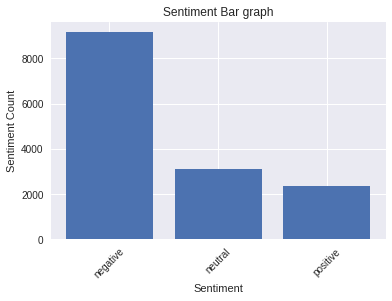

In [0]:
# LETS PLOT SENTIMENT FREQUENCIES BY CLASS
clas_index = [1, 2, 3]
plt.bar(clas_index, sent_freq)
plt.xticks(clas_index, ['negative', 'neutral', 'positive'], rotation=45)
plt.ylabel('Sentiment Count')
plt.xlabel('Sentiment')
plt.title('Sentiment Bar graph')

There clearly are way too many negative sentiments than neutral and positive. Solutions can include data argumentation or clipping off negative sentiment rows

Text(0.5, 1.0, 'Tweets per Airline Bar graph')

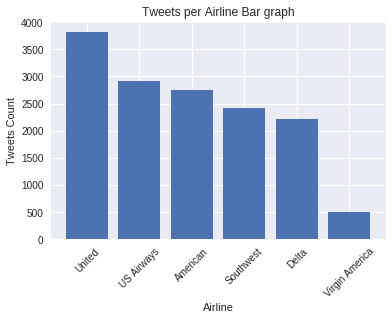

In [0]:
# LETS PLOT TWEETS PER AIRLINE
airline_index = [1, 2, 3, 4, 5, 6]
plt.bar(airline_index, airline_freq)
plt.xticks(airline_index,
    ['United', 'US Airways', 'American', 'Southwest',
     'Delta', 'Virgin America'] ,rotation=45)
plt.ylabel('Tweets Count')
plt.xlabel('Airline')
plt.title('Tweets per Airline Bar graph')

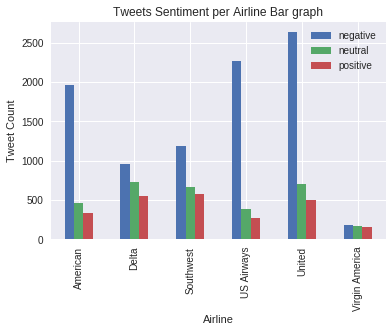

In [0]:
# LETS PLOT SENTIMENT FRQEUENCIES PER AIRLINE
airline_sent_clas_freq = {}
for airline in df['airline'].unique():
  df_p = df[df['airline']==airline]
  freqs = df_p['airline_sentiment'].value_counts()
  airline_sent_clas_freq[airline] = freqs
 
pd.DataFrame(airline_sent_clas_freq).T.plot(kind='bar')
plt.ylabel('Tweet Count')
plt.xlabel('Airline')
plt.title('Tweets Sentiment per Airline Bar graph')
plt.show()

### 1.c Data exploration outcomes
From the two previous graphs i.e. ***Tweets Sentiment per Airline Bar*** graph and ***Tweets per Airline Bar*** graph its is apparent that most tweets have a negative bias. Except for Virgin America, its tweets sentiments are almost evenly distributed. Training on this raw data set leads me to assume that the classifier will have a negatgive seintiment bias. Also sice tweets mention the airline, @airline_name, this could create an assosiation bias between the airline name and the sentiment. For instance it is most likely that any tweet with United in it will most likely be classified as negative since it has more negative sentiments than positive and neutral combined.

**Hypothesis**


1.   Remove airline names from tweets to minimize association bias

2.   Since we have more negative sentiment tweets than positive and neutral we can:
 > a. Augment Neutral and Positive tweets to match up to negative tweets numbers
 <br>
 > b. Clip out negative sentiment tweets




## 2 Data Prepation
In this stage we prepare our data based on our exporation analysis in prepation for training thus we test the hypothesis we came up with in step 1

<table>
  <tr>
    <th>DataFrame Name</th>
    <th>Pre-Processing</th>
   </tr>
  <tr>
    <td>df_raw</td>
    <td>None</td>
   </tr>
    <tr>
    <td>df_raw_no_name</td>
    <td>names i.e. @name removed</td>
   </tr>
  <tr>
    <td>df_aug</td>
    <td>neutral & positive sentiments augmented by randomizing the text</td>
   </tr>
  <tr>
    <td>df_aug_no_name</td>
    <td>df_aug + @name removed</td>
   </tr>
  <tr>
    <td>df_clpd</td>
    <td>negative sentiments clipped</td>
   </tr>
    <tr>
    <td>df_clpd_no_name</td>
    <td>df_clpd + @name removed </td>
   </tr>
 </table>
 
 All DataFrames are cleaned for unnecesary text.

In [0]:
# WE REMOVE UNWANTED COLUMS FFROM OUR DATAFRAME
df_raw = df[['airline_sentiment', 'text']]

In [0]:
# SGUFFLE DATASET IN WE WONT CLIPOUT OTHER AIRLINES
df_raw = shuffle(df_raw)

In [0]:
df_raw = df_raw.rename(columns={'airline_sentiment': 'label'})

In [0]:
# DATA AUGMENTATION
def augment(x, times=2):
  x_aug = []
  for i in range(int(times)):
    x = x.split(" ")
    x = shuffle(x)
    x = ' '.join(x)
    x_aug.append(x)
  return x_aug

df_gen = df_raw.loc[df_raw['label'] != 'negative']

temp_df_gen = df_gen

for i, row in temp_df_gen.iterrows():
  texts = augment(row['text'])
  _df = pd.DataFrame([[row['label'], texts[0]],
                      [row['label'], texts[1]]],
                     columns=['label', 'text'])
  df_gen = df_gen.append(_df, ignore_index=True)
  
df_aug = df_gen.append(df_raw, ignore_index=True)

In [0]:
# DATA CLIPPING
df_clpd = df_raw.loc[df_raw['label'] == 'negative']
df_non_neg = df_raw.loc[df_raw['label'] != 'negative']
df_clpd = df_clpd[:4000]
df_clpd = df_clpd.append(df_non_neg, ignore_index=True)

In [0]:
# REMOVE AIRLINE AND ANY MENTIONS
def remove_mentions(df):
  df['text'] = df['text'].apply( lambda x: [x for x in x.split()
                                              if not x.startswith('@')])
  return df

df_raw_no_name = remove_mentions(df_raw)
df_aug_no_name = remove_mentions(df_aug)
df_clpd_no_name = remove_mentions(df_clpd)

In [0]:
# TEXT CLEANING


In [0]:
# SPLIT DATA INTO TEST AND TRAINING SETS 
# We only use raw data test set as it is the only ground truth
df_raw_trn, df_raw_tst = train_test_split(df_raw, test_size=0.2)
# df_raw_no_name_trn, df_raw_no_name_tst = train_test_split(df_raw_no_name,
#                                                           test_size=0.2)

# df_aug_trn, df_aug_tst = train_test_split(df_aug, test_size=0.2)
# df_aug_no_name_trn, df_aug_no_name_tst = train_test_split(df_aug_no_name,
#                                                           test_size=0.2)

# df_clpd_trn, df_clpd_tst = train_test_split(df_clpd, test_size=0.2)
# df_clpd_trn_no_name, df_clpd_no_name_tst = train_test_split(df_clpd_no_name,
#                                                             test_size=0.2)

## 3. The model and classifiers
Now we create models to train  our model

In [0]:
# THIS PATH IS FOR FAST AI LIBRARY TO SAVE FILES
path = Path(os.getcwd())
path

PosixPath('/content')

Language model

In [0]:
def language_model(train, validation):
  data_lm = TextLMDataBunch.from_df(train_df=df_raw_trn, valid_df=df_raw_tst, path=path)
  data_cls = TextClasDataBunch.from_df(path, train_df=df_raw_trn, valid_df=df_raw_tst, vocab=data_lm.train_ds.vocab, bs=32)
  return data_lm, data_cls

Fin tune model

In [0]:
def fine_tune(data_lm):
  # 
  learn = language_model_learner(data_lm, AWD_LSTM, drop_mult=0.5)
  learn.fit_one_cycle(1, 1e-2)
  
  # unfreeze
  learn.unfreeze()
  learn.fit_one_cycle(1, 1e-3)
  
  # save weights
  learn.save_encoder('ft_enc')
  
  return learn

Classifier

In [0]:
def classify(learn, data_cls):
  learn = text_classifier_learner(data_cls, AWD_LSTM, drop_mult=0.5)
  learn.load_encoder('ft_enc')
  
#   data_cls.show_batch()
  
  learn.fit_one_cycle(1, 1e-2)
  
  learn.freeze_to(-2)
  learn.fit_one_cycle(2, slice(5e-3/2., 5e-3))
  
  learn.unfreeze()
  learn.fit_one_cycle(3, slice(2e-3/100, 2e-3))
  
#   learn.show_results()
  
  return learn

In [0]:
def predict(learn):
  learn.predict('This was a great ')
  learn.predict('this was the worst')
  learn.predict("no comment")
  learn.predict("@VirginAmerica help, left expensive headphones on flight 89 IAD to LAX today. Seat 2A. No one answering L&amp;F number at LAX!")

In [0]:
# RAW DATA CLASSIFIER
data_lm, data_cls = language_model(df_raw_trn, df_raw_tst)
learn = fine_tune(data_lm)
learn.predict("The flight", n_words=10)
learn_raw = classify(learn, data_cls)

epoch,train_loss,valid_loss,accuracy,time
1,1.841838,1.632146,0.725246,01:07


epoch,train_loss,valid_loss,accuracy,time
1,1.492209,1.382503,0.748061,01:26


epoch,train_loss,valid_loss,accuracy,time
1,0.796460,0.763325,0.668716,01:04


epoch,train_loss,valid_loss,accuracy,time
1,0.750138,0.669423,0.730874,01:15
2,0.710275,0.644813,0.749317,01:15


epoch,train_loss,valid_loss,accuracy,time
1,0.676620,0.598928,0.774932,02:26
2,0.668112,0.578922,0.783128,02:25
3,0.626168,0.576201,0.782104,02:26


In [0]:
# RAW DATA NO NAMES CLASSIFIER
data_lm, data_cls = language_model(df_raw_no_name, df_raw_tst)
learn = fine_tune(data_lm)
learn_raw_no_names = classify(learn, data_cls)

epoch,train_loss,valid_loss,accuracy,time
1,1.821114,1.629157,0.725070,01:08


epoch,train_loss,valid_loss,accuracy,time
1,1.509300,1.391972,0.747070,01:26


epoch,train_loss,valid_loss,accuracy,time
1,0.833824,0.735181,0.693989,01:04


epoch,train_loss,valid_loss,accuracy,time
1,0.763698,0.680151,0.729850,01:14
2,0.737062,0.637384,0.749317,01:14


epoch,train_loss,valid_loss,accuracy,time
1,0.683405,0.625226,0.757172,02:26
2,0.652367,0.572883,0.777322,02:26
3,0.645651,0.580207,0.780055,02:27


In [0]:
# AUGUMENTED DATA CLASSIFIER
data_lm, data_cls = language_model(df_aug, df_raw_tst)
learn = fine_tune(data_lm)
learn_aug = classify(learn, data_cls)

epoch,train_loss,valid_loss,accuracy,time
1,1.873399,1.644092,0.724168,01:08


epoch,train_loss,valid_loss,accuracy,time
1,1.478718,1.368108,0.749693,01:26


epoch,train_loss,valid_loss,accuracy,time
1,0.826515,0.769295,0.651981,01:04


epoch,train_loss,valid_loss,accuracy,time
1,0.748938,0.667377,0.737022,01:14
2,0.703491,0.614691,0.752391,01:14


epoch,train_loss,valid_loss,accuracy,time
1,0.661560,0.594662,0.770150,02:25
2,0.654336,0.585339,0.779030,02:27
3,0.619863,0.582343,0.777664,02:27


In [0]:
# AUGUMENTED DATA NO NAMES CLASSIFIER
data_lm, data_cls = language_model(df_aug_no_name, df_raw_tst)
learn = fine_tune(data_lm)
learn_aug_no_names = classify(learn, data_cls)

epoch,train_loss,valid_loss,accuracy,time
1,1.841493,1.634328,0.724665,01:08


epoch,train_loss,valid_loss,accuracy,time
1,1.494392,1.373494,0.748982,01:26


epoch,train_loss,valid_loss,accuracy,time
1,0.829574,0.734417,0.679986,01:03


epoch,train_loss,valid_loss,accuracy,time
1,0.753342,0.649930,0.741120,01:14
2,0.707894,0.612991,0.760246,01:14


epoch,train_loss,valid_loss,accuracy,time
1,0.673468,0.588256,0.774932,02:27
2,0.655792,0.584876,0.773566,02:26
3,0.604173,0.574176,0.777664,02:27


In [0]:
#CLIPPED DATA CLASSIFIER
data_lm, data_cls = language_model(df_clpd, df_raw_tst)
learn = fine_tune(data_lm)
learn_clpd = classify(learn, data_cls)

epoch,train_loss,valid_loss,accuracy,time
1,1.858084,1.631781,0.725316,01:08


epoch,train_loss,valid_loss,accuracy,time
1,1.495626,1.381737,0.748503,01:26


epoch,train_loss,valid_loss,accuracy,time
1,0.804306,0.717228,0.687842,01:03


epoch,train_loss,valid_loss,accuracy,time
1,0.734703,0.642278,0.747268,01:14
2,0.672714,0.591888,0.768443,01:14


epoch,train_loss,valid_loss,accuracy,time
1,0.658216,0.596858,0.773907,02:26
2,0.645084,0.562296,0.785178,02:26
3,0.642226,0.562681,0.782787,02:26


In [0]:
#CLIPPED DATA NO NAMES CLASSIFIER
data_lm, data_cls = language_model(df_clpd_no_name, df_raw_tst)
learn = fine_tune(data_lm)
learn_clpd_no_names = classify(learn, data_cls)

epoch,train_loss,valid_loss,accuracy,time
1,1.862038,1.638437,0.724507,01:08


epoch,train_loss,valid_loss,accuracy,time
1,1.487840,1.371664,0.749237,01:26


epoch,train_loss,valid_loss,accuracy,time
1,0.815174,0.738041,0.678962,01:03


epoch,train_loss,valid_loss,accuracy,time
1,0.748251,0.658074,0.719262,01:14
2,0.691307,0.598117,0.762637,01:16


epoch,train_loss,valid_loss,accuracy,time
1,0.691720,0.585058,0.781079,02:26
2,0.611191,0.558818,0.789276,02:26
3,0.639547,0.569888,0.782787,02:27


In [0]:
#CLIPPED DATA NO NAMES CLASSIFIER
data_lm, data_cls = language_model(df_clpd_trn, df_clpd_tst)
learn = fine_tune(data_lm)
learn_clpd_no_names_2 = classify(learn, data_cls)

epoch,train_loss,valid_loss,accuracy,time
1,1.839437,1.634294,0.726002,01:07


epoch,train_loss,valid_loss,accuracy,time
1,1.503808,1.387729,0.748178,01:26


epoch,train_loss,valid_loss,accuracy,time
1,0.827243,0.733669,0.674863,01:04


epoch,train_loss,valid_loss,accuracy,time
1,0.763181,0.684998,0.718579,01:14
2,0.680575,0.592659,0.759221,01:15


epoch,train_loss,valid_loss,accuracy,time
1,0.683985,0.574512,0.767760,02:24
2,0.621115,0.559867,0.783470,02:25
3,0.654875,0.560884,0.781762,02:25


### 4. Results

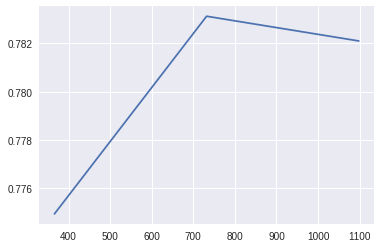

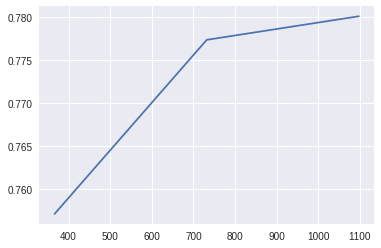

In [0]:
learn_raw.recorder.plot_metrics()
learn_raw_no_names.recorder.plot_metrics()

From the above Accuracy plots, it is clear that the dataset with no names makes a better model as the accuracy increases. As for the dataset with names the accuracy quickly drops as it starts to overfit i.e. associate names with sentiment.

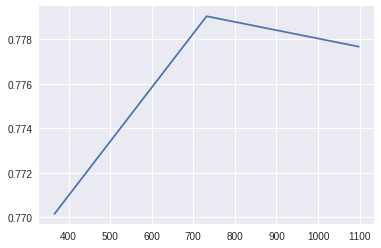

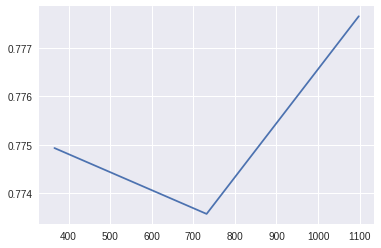

In [0]:
learn_aug.recorder.plot_metrics()
learn_aug_no_names.recorder.plot_metrics()

Same as from the first results, the accuracy of the dataset with names quickly overfits. The second plot is however interesing because the accuracy drops at first then it shoots up. This is because the model at first gets confused with the randomised text in the training set then figures it our and starts to rise. 

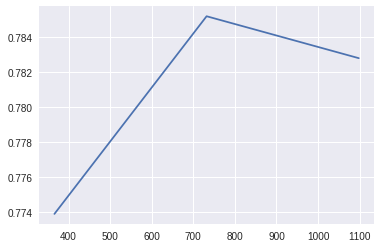

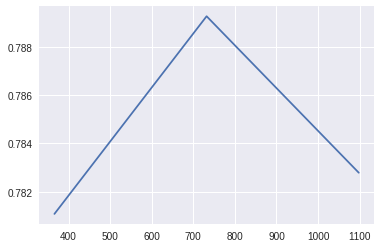

In [0]:
learn_clpd.recorder.plot_metrics()
learn_clpd_no_names.recorder.plot_metrics()

This turns out to be a disapointer. All the datasets produced models that are dropping in accuracy. The data clipping results in the model quickly overfitting to the training set thus the accuracy falls.

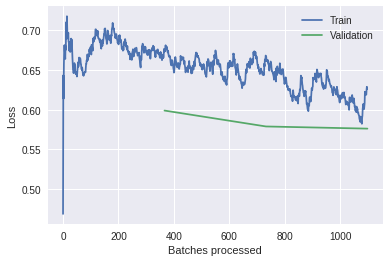

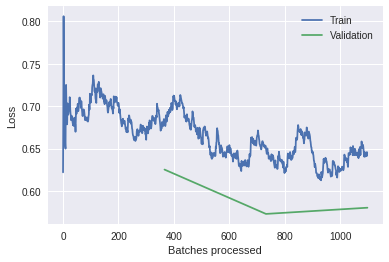

In [0]:
learn_raw.recorder.plot_losses()
learn_raw_no_names.recorder.plot_losses()

Even though the accuracy for the second data set was increasing, so at its loss which isn't a positive show. Probably the model is stating to overfit. This can be confirmed by futhter training the model. As for the raw dataset, the loss is still decresing but at a lower than initial rate.

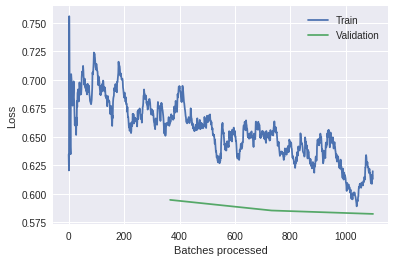

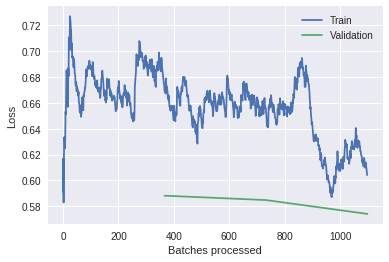

In [0]:
learn_aug.recorder.recorder.plot_losses()
learn_aug_no_names.recorder.plot_losses()

These two graphs are impressive. They are proving the hypothesis we made earlier to be correct. Augmenting data is good. Loss continues to go down for both datasets even better the dataset with no names he rate of decrease is going up as the accuracy is going up. This combination has a future.

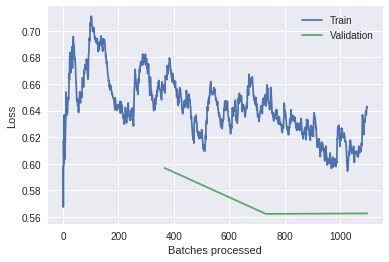

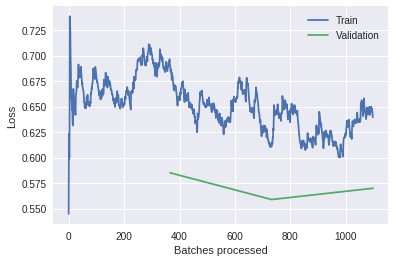

In [0]:
learn_clpd.recorder.recorder.plot_losses()
learn_clpd_no_names.recorder.plot_losses()

The above graphs just extrapolate that clipping data makes the model overfit. The losses are stating to increase which is bad for us "overfitting". Worse off the model with no names the rate of increase of loss has increased.

### 5. Conclusion
Clipping text form a text dataset to even avoid model over fitting is a bad idea. 
Keeping repetitive data that has nothing to do with deciphering sentimentfrom text data will not help create a good model. At least in our case. It would be useful if we want to identify brands or individuals with peoples sentiments for decision making purposes. Lastly aumenting data is clearly a good idea. It evens out the dataset and prevents model bias.
<br>
<br>
The shortcoming of this solution however was limited to dataset manipulation. Since UMLFit was suggested as a model, parameter optimization could improve results. We could run a grid search to find the most optimal parameters.
<br>
<br>
In conclusion if we continue to train our model with augumented data filtered of names we will most likey come up with the best model. 